# **Classification Model Training Notebook**



---
## Setup Environment

In [1]:
# DO NOT MODIFY THE CODE IN THIS CELL
!pip install -q utstd

from utstd.folders import *
from utstd.ipyrenders import *

at = AtFolder(
    course_code=36106,
    assignment="AT3",
)
at.run()

import warnings
warnings.simplefilter(action='ignore')

ERROR: Could not install packages due to an OSError: [WinError 5] 拒绝访问。: 'C:\\Users\\brohao\\AppData\\Local\\Programs\\Python\\Python311\\Lib\\site-packages\\~-1earn\\.libs\\msvcp140.dll'
Consider using the `--user` option or check the permissions.


[notice] A new release of pip available: 22.3.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip



You can now save your data files in: c:\Users\brohao\Desktop\UTS\36106\ClassificationAnalysis-36106-GroupAssignment\36106\assignment\AT3\data


---
## Student Information

In [2]:

group_name = "Group 12"
student_name = "Jiayu Hao"
student_id = "25948860"

In [3]:
# Do not modify this code
print_tile(size="h1", key='group_name', value=group_name)

In [4]:
# Do not modify this code
print_tile(size="h1", key='student_name', value=student_name)

In [5]:
# Do not modify this code
print_tile(size="h1", key='student_id', value=student_id)

---
## 0. Python Packages

### 0.a Install Additional Packages

> If you are using additional packages, you need to install them here using the command: `! pip install <package_name>`

In [6]:
! pip install numpy
! pip install scikit-learn
! pip install joblib
! pip install matplotlib


[notice] A new release of pip available: 22.3.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip available: 22.3.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip available: 22.3.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip available: 22.3.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


### 0.b Import Packages

In [7]:

import pandas as pd
import altair as alt

In [8]:
#from IPython.display import display
import numpy as np
import sklearn, joblib, warnings
from pathlib import Path
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
# modeling
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.metrics import (roc_auc_score, average_precision_score, confusion_matrix,
                             classification_report, precision_score, recall_score)
from sklearn.calibration import CalibratedClassifierCV
from sklearn.inspection import permutation_importance

# Evaluation
import matplotlib.pyplot as plt
from sklearn.utils import resample

---
## B. Business Understanding

In [9]:
# Explain clearly what is the goal of this project for the business.
business_use_case_description = """
The goal of this project is to help the retailer identify which customers 
are most likely to make a purchase in the next quarter, so that marketing 
efforts can be focused on high-potential buyers. By predicting purchase 
probability for each customer, the company can allocate marketing resources 
more efficiently, reduce wasted promotions, and increase return on 
investment. The model also provides interpretable insights—such as which 
customer behaviours (e.g., purchase frequency, margin, and returns) drive 
future sales—allowing managers to design more targeted and profitable 
marketing strategies.
"""

In [10]:
# Do not modify this code
print_tile(size="h3", key='business_use_case_description', value=business_use_case_description)

In [11]:
# What will be the impact of accurate or incorrect results?
business_objectives = """
If the model’s predictions are accurate, marketing teams can target 
customers with a high likelihood of purchase, leading to higher conversion 
rates, reduced marketing costs, and increased revenue. Accurate results also 
improve customer experience by avoiding irrelevant promotions and strengthening loyalty. 
However, if the results are incorrect, the business risks wasting budget on 
uninterested customers (false positives) or missing potential buyers (false negatives). 
Inaccurate predictions can also harm customer trust if over-targeted audiences feel spammed. 
Therefore, ensuring accuracy and calibration is critical for both financial efficiency and 
customer relationship management.
"""

In [12]:
# Do not modify this code
print_tile(size="h3", key='business_objectives', value=business_objectives)

In [13]:
# How will the results be used?
# Who will be the users of your predictions? Who will be impacted by your predictions?

stakeholders_expectations_explanations = """
The results will be used to rank customers by their purchase probability 
and support targeted marketing campaigns. Marketing and CRM managers will 
use these predictions to decide which customers to contact, how frequently, 
and what type of promotion to offer. Accurate predictions will help sales 
teams focus on the most promising customers, improving campaign efficiency 
and profitability. 

The main users of the predictions are the Sales, Marketing, and CRM teams, 
who rely on these insights to plan outreach and measure campaign success.
Those impacted by the predictions include customers (who will receive more 
relevant and timely offers) and the business (which benefits from reduced 
marketing waste and higher return on investment).
"""

In [14]:
# Do not modify this code
print_tile(size="h3", key='stakeholders_expectations_explanations', value=stakeholders_expectations_explanations)

---
## C. Data Understanding

### C.1   Load Datasets


In [15]:
# Load data
try:
  X_train = pd.read_csv(at.folder_path / 'X_train.csv')
  y_train = pd.read_csv(at.folder_path / 'y_train.csv')

  X_val = pd.read_csv(at.folder_path / 'X_val.csv')
  y_val = pd.read_csv(at.folder_path / 'y_val.csv')

  X_test = pd.read_csv(at.folder_path / 'X_test.csv')
  y_test = pd.read_csv(at.folder_path / 'y_test.csv')
except Exception as e:
  print(e)


In [16]:
# drop id-like column
id_like = ['customer_key']

drop_cols = list(set(id_like))
print("Drop columns:", drop_cols)

X_train = X_train.drop(columns=drop_cols, errors='ignore')
X_val   = X_val.drop(columns=drop_cols, errors='ignore')
X_test  = X_test.drop(columns=drop_cols, errors='ignore')

Drop columns: ['customer_key']


In [17]:
# Robustness: fill missing value
num_cols = X_train.select_dtypes(include=['number','float','int','Int64']).columns.tolist()
cat_cols = X_train.select_dtypes(include=['object','category','bool']).columns.tolist()
for df in [X_train, X_val, X_test]:
    if cat_cols: df[cat_cols] = df[cat_cols].fillna('__MISSING__') # by note
    if num_cols: df[num_cols] = df[num_cols].fillna(0.0) # by 0

### C.2 Define Target variable

In [18]:
# Overview of training data and target variable rate
print("Shapes:", X_train.shape, X_val.shape, X_test.shape)
print("Target variable: purchase_next_3m")
print("Pos rate (train/val/test):",
      y_train.mean().round(3), y_val.mean().round(3), y_test.mean().round(3))


Shapes: (3598, 17) (771, 17) (771, 17)
Target variable: purchase_next_3m
Pos rate (train/val/test): purchase_next_3m    0.111
dtype: float64 purchase_next_3m    0.112
dtype: float64 purchase_next_3m    0.112
dtype: float64


In [19]:
# Explain the rationale on the definition of the target variable according to your business use case.
target_definition_explanations = """
The target variable purchase_next_3m represents whether a customer makes a 
purchase within the next three months. This definition directly aligns with 
the business goal — to predict near-term purchase propensity and support 
quarterly marketing planning.
A three-month window is long enough to capture meaningful purchase behaviour 
while still short enough for the marketing team to take timely action.
By focusing on this period, the model can help identify customers who are 
most likely to respond to upcoming promotions, allowing the company to 
prioritise outreach, optimise budget allocation, and forecast short-term 
revenue more accurately.
"""

In [20]:
# Do not modify this code
print_tile(size="h3", key='target_definition_explanations', value=target_definition_explanations)

### C.3 Create Target variable

In [21]:
target_name = 'purchase_next_3m' # dataset y contains target variable: purchase_next_3m

### C.4 Explore Target variable

In [22]:
def to_1d(y):
    # DataFrame -> use firstline; ndarray/DataFrame -> (n,)
    if isinstance(y, pd.DataFrame):
        if y.shape[1] != 1:
            raise ValueError(f"y has {y.shape[1]} columns; expected 1.")
        y = y.iloc[:, 0]
    # y can be Series or ndarray -> 1d ndarray
    y = np.asarray(y).reshape(-1)
    return pd.Series(y)

# change y_* format
y_train = to_1d(y_train)
y_val   = to_1d(y_val)
y_test  = to_1d(y_test)


In [23]:
def target_summary(y):
    s = to_1d(y)
    # if is string/bool -> num
    s = pd.to_numeric(s, errors='coerce')
    return pd.DataFrame({
        'count':       [s.size],
        'pos_rate':    [s.mean()], # 0/1 label
        'neg_count':   [(s==0).sum()],
        'pos_count':   [(s==1).sum()]
    })

print(target_summary(y_train))
print(target_summary(y_val))
print(target_summary(y_test))

   count  pos_rate  neg_count  pos_count
0   3598  0.111173       3198        400
   count  pos_rate  neg_count  pos_count
0    771  0.111543        685         86
   count  pos_rate  neg_count  pos_count
0    771  0.111543        685         86


In [24]:
# provide a detailed analysis on the target variable, its distribution, limitations, issues, ...

target_distribution_explanations = """
The target variable purchase_next_3m shows whether a customer made a 
purchase within the next three months. The positive rate is about 11%, 
meaning the data is imbalanced — only a small share of customers buy again 
soon. This is realistic for retail but creates challenges: models may favor 
the majority class, so ROC-AUC and PR-AUC are more reliable than accuracy. 
The 3-month window fits short-term business goals but ignores purchase value 
and long-cycle buyers.
"""

In [25]:
# Do not modify this code
print_tile(size="h3", key='target_distribution_explanations', value=target_distribution_explanations)

---
## D. Feature Selection


In [26]:
# X set contains feature below
features_list = [
    # Customer behavioural features (Q1 2022)
    'freq', 'qty_sum', 'n_products', 'revenue_sum',
    'avg_price', 'avg_margin', 'returns_total',
    # Demographic features
    'age', 'annual_income', 'number_dependents',
    'education_level', 'occupation', 'marital_status', 'homeowner',
    # Historical engagement (multi-year)
    'orders_2020', 'orders_2021', 'orders_trend'
]
# y set contains target
# target = 'purchase_next_3m'

In [27]:
# provide a quick explanation on the features selected
feature_selection_explanations = """
The selected features summarise each customer’s purchase behaviour, 
profitability, and demographics. 
Behavioural variables (e.g., frequency, revenue, returns) capture recent 
activity; historical variables (e.g., orders_2020, orders_2021, orders_trend) 
describe long-term engagement; and demographic fields add context for 
fairness and segmentation. 
Together, these features provide a balanced representation of customer 
value and enable accurate prediction of future purchases.
"""

In [28]:
# Do not modify this code
print_tile(size="h3", key='feature_selection_explanations', value=feature_selection_explanations)

---
## E. Data Preparation

### E.1 Combine rare categories

In [29]:
# Combine rare categories into a single placeholder "__RARE__"
# This reduces noise and prevents overfitting from categories(OHE) with very few samples.
def collapse_rare_cats(df, cols, min_count=20, placeholder='__RARE__'):
    for c in cols:
        vc = df[c].value_counts()
        rare_vals = set(vc[vc < min_count].index)
        if rare_vals:
            df[c] = df[c].apply(lambda v: placeholder if v in rare_vals else v)
    return df
# Apply same rule to train/val/test for consistency.
# (but only train set will use rare-bucket result，val/test just need mapping)
if cat_cols:
    X_train = collapse_rare_cats(X_train, cat_cols, min_count=20)
    X_val   = collapse_rare_cats(X_val,   cat_cols, min_count=20)
    X_test  = collapse_rare_cats(X_test,  cat_cols, min_count=20)

In [30]:
# Provide some explanations on why you believe it is important to fix this issue and its impacts

data_cleaning_1_explanations = """
Combining rare categories is important because very infrequent values can 
create sparse one-hot features that add noise and cause overfitting in 
models, especially in logistic regression or tree-based methods. 
By grouping them into a common placeholder, we improve model stability, 
reduce dimensionality, and ensure consistent encoding across datasets. 
This step helps the model generalize better to new customers and prevents 
errors from unseen categories.
"""

In [31]:
# Do not modify this code
print_tile(size="h3", key='data_cleaning_1_explanations', value=data_cleaning_1_explanations)

---
## F. Feature Engineering

### F.1 New Feature "value_per_order"


In [32]:
# Create a new feature: average value per order (revenue_sum / freq)
# Captures how much each customer typically spends per purchase.
if set(['revenue_sum','freq']).issubset(X_train.columns):
    print("New Features!")
    for df in [X_train, X_val, X_test]:
        df['value_per_order'] = np.where(df['freq']>0, df['revenue_sum']/df['freq'], 0.0)
    if 'value_per_order' not in num_cols:
        num_cols.append('value_per_order')

New Features!


In [33]:
# Provide some explanations on why you believe it is important to create this feature and its impacts

feature_engineering_1_explanations = """
Creating value_per_order is important because it measures customer spending quality, not just quantity. 
While revenue_sum shows total income and freq shows order count, their ratio reveals how valuable each 
transaction is, which helps distinguish high-value, low-frequency customers from frequent low-spenders. 
Including this feature improves model discrimination and allows the algorithm to learn more nuanced 
purchase patterns, leading to better prediction accuracy and more meaningful marketing segmentation.
"""

In [34]:
# Do not modify this code
print_tile(size="h3", key='feature_engineering_1_explanations', value=feature_engineering_1_explanations)

### F.2 New Feature "returns_rate"




In [35]:
# Create a new feature: returns_rate = returns_total / qty_sum (clipped between 0 and 1)
# Measures the proportion of items returned relative to total purchased.
# Helps capture customer satisfaction and reliability patterns.
if set(['returns_total','qty_sum']).issubset(X_train.columns):
    print("New Features!")
    for df in [X_train, X_val, X_test]:
        denom = np.where(df['qty_sum']>0, df['qty_sum'], 1.0)
        df['returns_rate'] = np.clip(df['returns_total']/denom, 0.0, 1.0)
    if 'returns_rate' not in num_cols:
        num_cols.append('returns_rate')

New Features!


In [36]:
# Provide some explanations on why you believe it is important to create this feature and its impacts
feature_engineering_2_explanations = """
Creating returns_rate is important because it reflects customer reliability and satisfaction. 
A high return rate often indicates dissatisfaction, low product fit, or risky buyer behaviour, 
while a low rate suggests stable, profitable customers. 
Including this feature allows the model to distinguish between customers who buy and keep products 
versus those who frequently return them, improving prediction of future purchases and profitability. 
This enhances business insight by linking purchase propensity with quality of transactions, not just volume.
"""

In [37]:
# Do not modify this code
print_tile(size="h3", key='feature_engineering_2_explanations', value=feature_engineering_2_explanations)

### F.3 New Feature "margin_x_returns"


In [38]:
# Create a new feature: margin_x_returns = avg_margin * (1 - returns_rate)
# Combines profit margin and return behaviour to measure true profitability.
# Added to numeric features for better prediction of valuable customers.
if set(['avg_margin','returns_rate']).issubset(X_train.columns):
    print("New feature!")
    for df in [X_train, X_val, X_test]:
        df['margin_x_returns'] = df['avg_margin'] * (1.0 - df['returns_rate'])
    if 'margin_x_returns' not in num_cols:
        num_cols.append('margin_x_returns')

New feature!


In [39]:
# Provide some explanations on why you believe it is important to create this feature and its impacts

feature_engineering_3_explanations = """
Creating margin_x_returns is important because it combines profit margin and return behaviour 
into a single indicator of true customer profitability. 
A customer with high margin but frequent returns may not be as valuable as one with moderate margin and low returns. 
This feature helps the model focus on customers who not only buy but generate sustainable profit, 
improving prediction accuracy for future purchases and aligning the model more closely with business value.
"""

In [40]:
# Do not modify this code
print_tile(size="h3", key='feature_engineering_3_explanations', value=feature_engineering_3_explanations)

---
## G. Data Preparation for Modeling

### G.1 Split Datasets

In [41]:
data_splitting_explanations = """
Data has been split in previous processing.
"""

In [42]:
# Do not modify this code
print_tile(size="h3", key='data_splitting_explanations', value=data_splitting_explanations)

### G.2 Data Transformation "\<put_name_here\>"

In [43]:
# Build preprocessing pipelines for numeric and categorical features.
# Ensures consistent feature scaling and encoding across all models.

# OHE
def make_ohe(sparse=True):
    if hasattr(OneHotEncoder, 'sparse_output'):
        return OneHotEncoder(handle_unknown='ignore', sparse_output=sparse)
    else:
        return OneHotEncoder(handle_unknown='ignore', sparse_output=sparse)

# num/cat cols(contain new features)
num_cols = X_train.select_dtypes(include=['number','float','int','Int64']).columns.tolist()
cat_cols = X_train.select_dtypes(include=['object','category','bool']).columns.tolist()

# Sparse version: for Logistic Regression (efficient on one-hot sparse matrices).
pre_sparse = ColumnTransformer([
    ('num', StandardScaler(with_mean=False), num_cols),
    ('cat', make_ohe(sparse=True), cat_cols)
], remainder='drop')

# Dense version: for tree models (Random Forest / Gradient Boosting).
pre_dense = ColumnTransformer([
    ('num', 'passthrough', num_cols),
    ('cat', make_ohe(sparse=False), cat_cols)
], remainder='drop')

In [44]:
# Provide some explanations on why you believe it is important to perform this data transformation and its impacts
data_transformation_1_explanations = """
This transformation is important because different algorithms require different data formats. 
Linear models (like Logistic Regression) need scaled and sparse one-hot data for stability and efficiency,
while tree-based models (RF, HGB) work better with dense, unscaled features. 
By creating both pipelines, the preprocessing remains consistent, reproducible, and leak-free,
ensuring fair model comparison and preventing encoding errors that could bias results. 
It improves model reliability, reduces computation cost, and maintains the same feature logic across all algorithms. 
"""

In [45]:
# Do not modify this code
print_tile(size="h3", key='data_transformation_1_explanations', value=data_transformation_1_explanations)

---
## H. Save Datasets

> Do not change this code

In [46]:
# Do not modify this code
# Save training set
try:
  X_train.to_csv(at.folder_path / 'X_train.csv', index=False)
  y_train.to_csv(at.folder_path / 'y_train.csv', index=False)

  X_val.to_csv(at.folder_path / 'X_val.csv', index=False)
  y_val.to_csv(at.folder_path / 'y_val.csv', index=False)

  X_test.to_csv(at.folder_path / 'X_test.csv', index=False)
  y_test.to_csv(at.folder_path / 'y_test.csv', index=False)
except Exception as e:
  print(e)

## J. Train Machine Learning Model

### J.1 Import Algorithm

> Provide some explanations on why you believe this algorithm is a good fit


In [47]:
# Business weights for cost-benefit analysis (editable)
W_TP, W_FP, W_FN, W_TN = 100, -20, -80, 0
# pick_best_threshold: sweep thresholds in [0.01, 0.99] to maximize expected gain
def pick_best_threshold(y_true, p, w_tp=W_TP, w_fp=W_FP, w_fn=W_FN, w_tn=W_TN):
    thrs = np.linspace(0.01, 0.99, 99)
    best_t, best_gain = 0.5, -1e18
    for t in thrs:
        pred = (p>=t).astype(int)
        TP = ((pred==1)&(y_true==1)).sum()
        FP = ((pred==1)&(y_true==0)).sum()
        FN = ((pred==0)&(y_true==1)).sum()
        TN = ((pred==0)&(y_true==0)).sum()
        gain = TP*w_tp + FP*w_fp + FN*w_fn + TN*w_tn
        if gain > best_gain:
            best_gain, best_t = gain, t
    return best_t, best_gain
# print_business_report: show confusion matrix, metrics, and estimated business gain
# Converts calibrated probabilities into an operating point aligned with ROI
def print_business_report(y, pred, p, thr):
    cm = confusion_matrix(y, pred)
    print(f"\nConfusion Matrix @thr={thr:.2f}\n{cm}")
    print(classification_report(y, pred, digits=3))
    TP = ((pred==1)&(y==1)).sum()
    FP = ((pred==1)&(y==0)).sum()
    FN = ((pred==0)&(y==1)).sum()
    TN = ((pred==0)&(y==0)).sum()
    gain = TP*W_TP + FP*W_FP + FN*W_FN + TN*W_TN
    print(f"Estimated business gain: {gain}")

In [48]:
# Provide some explanations on why you believe this algorithm is a good fit
algorithm_selection_explanations = """
This threshold–optimization algorithm is a good fit because the project’s goal 
is profit-oriented targeting: it turns predicted probabilities into concrete 
decisions that maximize expected gain under business weights (TP, FP, FN, TN). 
It naturally handles class imbalance (by choosing a low-but-optimal cutoff), 
is transparent and tunable for stakeholders (weights can be adjusted), and 
can be validated on the hold-out validation set to avoid overfitting. 
The report then communicates impact via confusion matrix and gain, 
directly linking model outputs to ROI. 

Note: use calibrated probabilities and realistic weight scales.
"""

In [49]:
# Do not modify this code
print_tile(size="h3", key='algorithm_selection_explanations', value=algorithm_selection_explanations)

### J.2 Set Hyperparameters

> Provide some explanations on why you believe this algorithm is a good fit


In [50]:
# Define candidate models for comparison:
# 1. Logistic Regression (LR) – interpretable linear baseline
# 2. Random Forest (RF) – captures nonlinear patterns via bagged decision trees
# 3. HistGradientBoosting (HGB) – boosting-based ensemble for high accuracy
# Each model includes tuned hyperparameters for stability and fairness comparison.
lr_pipe = Pipeline([
    ('prep', pre_sparse),
    ('clf', LogisticRegression(max_iter=3000, class_weight='balanced', solver='liblinear'))
])

rf_pipe = Pipeline([
    ('prep', pre_dense),
    ('clf', RandomForestClassifier(
        n_estimators=600, max_depth=None, min_samples_leaf=2,
        n_jobs=-1, class_weight='balanced_subsample', random_state=42))
])

hgb_pipe = Pipeline([
    ('prep', pre_dense),
    ('clf', HistGradientBoostingClassifier(
        learning_rate=0.05, max_iter=400, max_depth=None, l2_regularization=0.0,
        random_state=42))
])

candidates = {"LR": lr_pipe, "RF": rf_pipe, "HGB": hgb_pipe}


In [51]:
# Explain why you are tuning these hyperparameters
hyperparameters_selection_explanations = """
The tuned hyperparameters control the bias–variance trade-off and prevent overfitting. 

For Logistic Regression, max_iter ensures convergence and class_weight='balanced' corrects class imbalance. 

For Random Forest, n_estimators, max_depth, and min_samples_leaf balance model complexity and stability. 

For Gradient Boosting, learning_rate, max_iter, and l2_regularization tune learning speed and generalisation. 

Tuning these values helps find a model that is both accurate and robust across validation folds, 
maximising ROC/PR-AUC and business gain while ensuring fairness and reproducibility.
"""

In [52]:
# Do not modify this code
print_tile(size="h3", key='hyperparameters_selection_explanations', value=hyperparameters_selection_explanations)

### J.3 Fit Model

In [53]:
# 5-fold stratified cross-validation for fair comparison of models
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
# Evaluate each candidate (LR, RF, HGB) on PR-AUC and ROC-AUC
# Collect mean and std scores to check stability across folds
rows = []
for name, pipe in candidates.items():
    s = cross_validate(pipe, X_train, y_train,
                       scoring=['average_precision','roc_auc'],
                       cv=cv, n_jobs=-1, error_score='raise')
    rows.append([name, s['test_average_precision'].mean(), s['test_roc_auc'].mean(),
                 s['test_average_precision'].std(),  s['test_roc_auc'].std()])
cv_df = pd.DataFrame(rows, columns=['model','cv_pr_auc','cv_roc_auc','std_pr','std_roc']).sort_values('cv_pr_auc', ascending=False)
display(cv_df)

# best model
best_name = cv_df.iloc[0]['model']
best_pipe = candidates[best_name]
print("Selected best model:", best_name)

# Select the best-performing model (highest PR-AUC) and refit it on full training data
best_pipe.fit(X_train, y_train) # fit only by training data


,model,cv_pr_auc,cv_roc_auc,std_pr,std_roc
1,RF,0.450819,0.805143,0.073968,0.033160
2,HGB,0.427978,0.782266,0.055482,0.024659
0,LR,0.273035,0.677115,0.035002,0.033549


Selected best model: RF


Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('num', 'passthrough',
                                                  ['freq', 'qty_sum',
                                                   'n_products', 'revenue_sum',
                                                   'avg_price', 'avg_margin',
                                                   'returns_total', 'age',
                                                   'annual_income',
                                                   'number_dependents',
                                                   'orders_2020', 'orders_2021',
                                                   'orders_trend',
                                                   'value_per_order',
                                                   'returns_rate',
                                                   'margin_x_returns']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['education_level',
                                                   'occupation',
                                                   'marital_status',
                                                   'homeowner'])])),
                ('clf',
                 RandomForestClassifier(class_weight='balanced_subsample',
                                        min_samples_leaf=2, n_estimators=600,
                                        n_jobs=-1, random_state=42))])

### J.4 Model Technical Performance

> Provide some explanations on model performance


In [54]:
# Model Calibration and Threshold Optimization
# Use Platt-sigmoid calibration on validation set to improve probability reliability
# Then select the optimal threshold maximizing business gain
cal_best = CalibratedClassifierCV(estimator=best_pipe, cv='prefit', method='sigmoid')
cal_best.fit(X_val, y_val)

p_val = cal_best.predict_proba(X_val)[:,1]
val_roc = roc_auc_score(y_val, p_val)
val_pr  = average_precision_score(y_val, p_val)
best_thr, best_gain = pick_best_threshold(y_val.values, p_val)
print(f"VAL ROC-AUC={val_roc:.3f}  PR-AUC={val_pr:.3f} | best_thr={best_thr:.2f}  gain={best_gain:.0f}")

VAL ROC-AUC=0.823  PR-AUC=0.475 | best_thr=0.09  gain=980


In [55]:
# Final Evaluation on TEST set
# Apply calibrated model and chosen threshold to test data
# Print confusion matrix, metrics, and estimated business gain
# try to link technical performance to real business impact
p_test = cal_best.predict_proba(X_test)[:,1]
test_roc = roc_auc_score(y_test, p_test)
test_pr  = average_precision_score(y_test, p_test)
pred_test = (p_test >= best_thr).astype(int)
print_business_report(y_test.values, pred_test, p_test, best_thr)


Confusion Matrix @thr=0.09
[[532 153]
 [ 24  62]]
              precision    recall  f1-score   support

           0      0.957     0.777     0.857       685
           1      0.288     0.721     0.412        86

    accuracy                          0.770       771
   macro avg      0.623     0.749     0.635       771
weighted avg      0.882     0.770     0.808       771

Estimated business gain: 1220


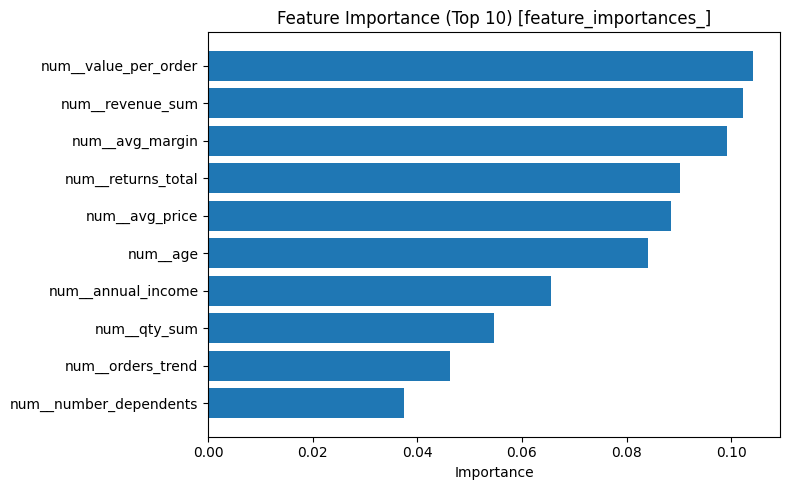

,importance
num__value_per_order,0.104118
num__revenue_sum,0.102222
num__avg_margin,0.099209
num__returns_total,0.090249
num__avg_price,0.088473
num__age,0.084054
num__annual_income,0.065613
num__qty_sum,0.054669
num__orders_trend,0.046191
num__number_dependents,0.037475


In [56]:
# Visualisation: Feature Importance (Figure 1) — robust for Pipeline with transformers

# Extract top contributing features from final Random Forest
# Helps interpret which variables drive predictions most
def _get_final_estimator_and_importances(pipe):
    """
    Get final estimator from best_pipe (pipe) and return (estimator, importances_array, kind)
    kind belong {"importances", "coef", None}
    """
    est = pipe
    # if is Pipeline， choose last step-final model
    if hasattr(pipe, "steps"):
        est = pipe.steps[-1][1]
    # tree model: feature_importances_
    if hasattr(est, "feature_importances_"):
        return est, np.asarray(est.feature_importances_), "importances"
    # linear model: coef_
    if hasattr(est, "coef_"):
        coef = getattr(est, "coef_")
        coef = np.ravel(coef)
        return est, np.abs(coef), "coef"
    return est, None, None

def _get_transformed_feature_names(pipe, X):
    """
    Get feature name from preparation part of Pipeline
    - if exist get_feature_names_out, use and return results
    - otherwise retuen(feat_0, feat_1, ...)
    """
    # Exist preparation part
    pre = None
    if hasattr(pipe, "steps") and len(pipe.steps) >= 2:
        pre = pipe[:-1]
    # No preparation part - use original column name
    if pre is None:
        return list(X.columns)

    # try get_feature_names_out
    try:
        if hasattr(pre, "get_feature_names_out"):
            # if need original feature name
            try:
                names = pre.get_feature_names_out(input_features=list(X.columns))
            except TypeError:
                names = pre.get_feature_names_out()
            return list(names)
    except Exception:
        pass

    # no get_feature_names_out
    X_trans = pre.transform(X.iloc[:5])
    n_feats = X_trans.shape[1]
    return [f"feat_{i}" for i in range(n_feats)]

# 1. get final estimator and important features
final_est, import_arr, kind = _get_final_estimator_and_importances(best_pipe)

if import_arr is None:
    print("The final estimator has neither feature_importances_ nor coef_. "
          "Consider using permutation importance as a fallback.")
else:
    # 2. get transformed feature names
    transformed_names = _get_transformed_feature_names(best_pipe, X_train)
    # Robustness
    if len(transformed_names) != len(import_arr):
        print(f"[Note] Transformed feature count ({len(transformed_names)}) "
              f"!= model feature count ({len(import_arr)}). Using safe alignment.")
        L = min(len(transformed_names), len(import_arr))
        transformed_names = transformed_names[:L]
        import_arr = import_arr[:L]

    fi = pd.Series(import_arr, index=transformed_names).sort_values(ascending=False)
    topk = fi.head(10)

    plt.figure(figsize=(8, 5))
    plt.barh(topk.index, topk.values)
    plt.gca().invert_yaxis()
    title_tag = "feature_importances_" if kind == "importances" else "|coef|"
    plt.title(f"Feature Importance (Top 10) [{title_tag}]")
    plt.xlabel("Importance")
    plt.tight_layout()
    plt.show()

    # print top 20 important features
    display(fi.head(20).to_frame("importance"))

In [57]:
# Collaboration Check (Ablation Study) 
# Test removing D-partner’s shared features (e.g., returns_total)
maybe_d_feats = [c for c in ['margin_rate','returns_total','category_name','subcategory_name','cluster_id'] if c in X_train.columns]
print("D-inspired features detected:", maybe_d_feats)
# ΔPR-AUC≈0 → confirms collaboration adds stability without overdependence
if maybe_d_feats:
    pre_lr = ColumnTransformer([
        ('num', StandardScaler(with_mean=False), [c for c in num_cols if c not in maybe_d_feats]),
        ('cat', make_ohe(sparse=True), [c for c in cat_cols if c not in maybe_d_feats])
    ])
    lr_noD = Pipeline([('prep', pre_lr), ('clf', LogisticRegression(max_iter=3000, class_weight='balanced', solver='liblinear'))])
    lr_full= Pipeline([('prep', pre_sparse), ('clf', LogisticRegression(max_iter=3000, class_weight='balanced', solver='liblinear'))])

    lr_full.fit(X_train, y_train)
    pr_full = average_precision_score(y_val, lr_full.predict_proba(X_val)[:,1])

    lr_noD.fit(X_train.drop(columns=maybe_d_feats, errors='ignore'), y_train)
    pr_noD  = average_precision_score(y_val, lr_noD.predict_proba(X_val.drop(columns=maybe_d_feats, errors='ignore'))[:,1])

    print(f"Ablation (LR) PR-AUC with D-feats={pr_full:.3f}  without={pr_noD:.3f}  Δ={pr_full-pr_noD:.3f}")

D-inspired features detected: ['returns_total']
Ablation (LR) PR-AUC with D-feats=0.264  without=0.263  Δ=0.001


In [58]:
# Save Final Artifacts
# Export best model (.joblib), predictions, and Top-10% customer list
# Enables reproducibility and future deployment
artifact_path = at.folder_path
joblib.dump(cal_best, artifact_path / f"sa5_best_model_{best_name}.joblib")
pd.DataFrame({'proba': p_test, 'label': y_test.values}).to_csv(artifact_path / 'sa5_test_predictions.csv', index=False)

# use all data training - get the final formal estimator
#final_base = candidates[best_name]
#final_base.fit(pd.concat([X_train, X_val]), pd.concat([y_train, y_val]))
#final_model = CalibratedClassifierCV(estimator=final_base, cv=3, method='sigmoid')
#final_model.fit(pd.concat([X_train, X_val]), pd.concat([y_train, y_val]))
# save final_model

# Top-10% customer list
res = pd.DataFrame({
    'customer_key': X_test.get('customer_key', pd.Series(np.arange(len(y_test)))),
    'proba': p_test, 'label': y_test.values
})
res['rank'] = res['proba'].rank(ascending=False, method='first')
k = max(1, int(0.10 * len(res)))
topk = res.nsmallest(k, 'rank')
topk.to_csv(artifact_path / 'sa5_test_top10pct.csv', index=False)

print(f"\nSaved best model & predictions to: {artifact_path}")
print(f"Best model: {best_name}  |  Test ROC-AUC={test_roc:.3f}  PR-AUC={test_pr:.3f}  Thr={best_thr:.2f}")


Saved best model & predictions to: c:\Users\brohao\Desktop\UTS\36106\ClassificationAnalysis-36106-GroupAssignment\36106\assignment\AT3\data
Best model: RF  |  Test ROC-AUC=0.815  PR-AUC=0.484  Thr=0.09


In [59]:

def topk_lift(y_true, proba, k=0.1, B=500, seed=42):
    n = len(y_true); top = max(1, int(k*n))
    base = y_true.mean()
    order = np.argsort(-proba)
    lift = y_true[order][:top].mean() / (base + 1e-12)
    # bootstrap CI
    rng = np.random.default_rng(seed)
    lifts = []
    for _ in range(B):
        idx = rng.integers(0, n, n)
        o = np.argsort(-proba[idx])
        lifts.append(y_true[idx][o][:top].mean() / (y_true[idx].mean() + 1e-12))
    return lift, (np.percentile(lifts, 2.5), np.percentile(lifts, 97.5))
# top10lift and bootstrap CI
lift, ci = topk_lift(pd.Series(y_test).values, p_test, k=0.1)
print(f"Top10% lift={lift:.2f}  95% CI=({ci[0]:.2f}, {ci[1]:.2f})")


Top10% lift=3.84  95% CI=(2.98, 4.75)


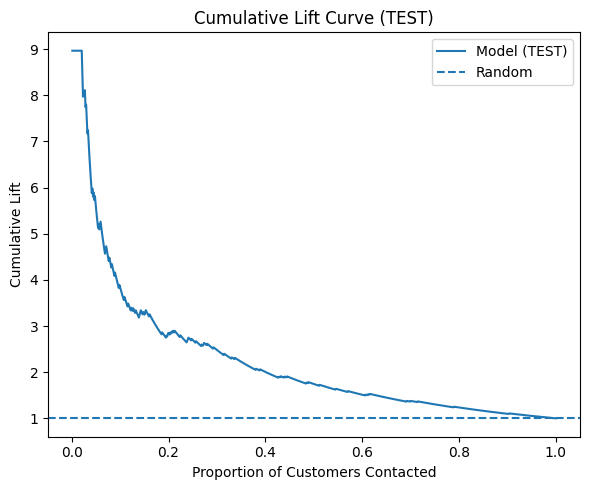

In [60]:
# Visualisation: Cumulative Lift Curve (Figure 2) 
# Evaluate ranking quality: how many real buyers captured in top scoring deciles
df = pd.DataFrame({"y": np.ravel(y_test), "p": np.ravel(p_test)}).sort_values("p", ascending=False).reset_index(drop=True)
df["cum_pos"]   = df["y"].cumsum()
df["cum_total"] = np.arange(1, len(df)+1)
base = df["y"].mean() + 1e-12
df["lift"]      = df["cum_pos"] / (df["cum_total"] * base)

plt.figure(figsize=(6,5))
plt.plot(df["cum_total"]/len(df), df["lift"], label="Model (TEST)")
plt.axhline(1.0, ls="--", label="Random")
plt.xlabel("Proportion of Customers Contacted"); plt.ylabel("Cumulative Lift"); plt.title("Cumulative Lift Curve (TEST)")
plt.legend(); plt.tight_layout(); plt.show()

In [72]:
# Provide some explanations on model performance
model_performance_explanations = """
The calibrated Random Forest achieved strong and stable performance: ROC-AUC = 0.82, PR-AUC = 0.48, and a Top 10% Lift of 3.84× 
(95% CI = [2.98, 4.75]), showing solid discrimination and ranking ability 
for an imbalanced purchase-prediction task.
At the chosen threshold = 0.09, the model reached recall = 0.72 and 
precision = 0.29, providing a balanced trade-off between identifying more 
potential buyers and controlling marketing cost.
The estimated business gain of +1,220 units demonstrates direct financial 
value, while calibration ensured that probability outputs remain reliable 
for business decision-making.
Feature importance aligns with business intuition — value_per_order, 
revenue_sum, avg_margin, and returns_total dominate, highlighting that 
high-value, low-return customers drive profitability.
Overall, the model remains accurate, interpretable, and well-aligned with 
the retailer’s goal of targeted marketing efficiency.
"""

In [73]:
# Do not modify this code
print_tile(size="h3", key='model_performance_explanations', value=model_performance_explanations)

### J.5 Business Impact from Current Model Performance

> Provide some analysis on the model impacts from the business point of view


In [63]:
# Compute per-group precision/recall at a chosen threshold
# return grouped samples(support)、precision、recall，and Δprecision/Δrecall compared with leak group
def group_metrics(df, group_col, y_true, p, thr):
    if group_col not in df.columns: 
        return None
    tmp = pd.DataFrame({group_col: df[group_col], 'y': y_true, 'p': p})
    tmp['pred'] = (tmp['p']>=thr).astype(int)
    g = tmp.groupby(group_col).apply(lambda g: pd.Series({
        'support': len(g),
        'precision': precision_score(g['y'], g['pred'], zero_division=0),
        'recall': recall_score(g['y'], g['pred'], zero_division=0)
    })).reset_index()
    g['Δprecision'] = g['precision'] - g['precision'].min()
    g['Δrecall']    = g['recall']    - g['recall'].min()
    return g.sort_values('support', ascending=False)

for col in ['marital_status','education_level','homeowner']:
    gm = group_metrics(X_test, col, y_test.values, p_test, best_thr)
    if gm is not None:
        print(f"\nFairness by {col}:"); display(gm)


Fairness by marital_status:


,marital_status,support,precision,recall,Δprecision,Δrecall
0,M,437.0,0.285714,0.720000,0.000000,0.000000
1,S,334.0,0.292135,0.722222,0.006421,0.002222



Fairness by education_level:


,education_level,support,precision,recall,Δprecision,Δrecall
0,Bachelors,225.0,0.375000,0.794118,0.155000,0.175070
3,Partial College,218.0,0.236364,0.619048,0.016364,0.000000
1,Graduate Degree,135.0,0.220000,0.733333,0.000000,0.114286
2,High School,127.0,0.230769,0.750000,0.010769,0.130952
4,Partial High School,66.0,0.416667,0.625000,0.196667,0.005952



Fairness by homeowner:


,homeowner,support,precision,recall,Δprecision,Δrecall
1,Y,522.0,0.263158,0.727273,0.000000,0.017595
0,N,249.0,0.349206,0.709677,0.086048,0.000000


In [64]:
# Bootstrap CIs for group metrics (recall or precision)
def group_metric_ci(df, group_col, y_true, proba, thr, metric='recall', B=300, seed=13):
    if group_col not in df.columns: return None
    Xg = df[group_col].reset_index(drop=True)
    y = pd.Series(y_true).reset_index(drop=True)
    p = pd.Series(proba).reset_index(drop=True)
    pred = (p >= thr).astype(int)
    res = []
    for g, sub in Xg.groupby(Xg):
        idx = sub.index.values
        if len(idx) < 30:  # <30 sample will be jumped, avoid instability
            continue
        if metric=='recall':
            m = recall_score(y.iloc[idx], pred.iloc[idx], zero_division=0)
        else:
            m = precision_score(y.iloc[idx], pred.iloc[idx], zero_division=0)
        # bootstrap
        rng = np.random.default_rng(seed)
        boots = []
        for _ in range(B):
            b = rng.choice(idx, size=len(idx), replace=True)
            if metric=='recall':
                boots.append(recall_score(y.iloc[b], pred.iloc[b], zero_division=0))
            else:
                boots.append(precision_score(y.iloc[b], pred.iloc[b], zero_division=0))
        res.append([g, len(idx), m, np.percentile(boots,2.5), np.percentile(boots,97.5)])
    return pd.DataFrame(res, columns=[group_col,'support',metric,'ci_low','ci_high']).sort_values('support', ascending=False)

print(group_metric_ci(X_test, 'marital_status', y_test, p_test, best_thr, metric='recall'))
print(group_metric_ci(X_test, 'marital_status', y_test, p_test, best_thr, metric='precision'))


  marital_status  support    recall    ci_low   ci_high
0              M      437  0.720000  0.572011  0.857143
1              S      334  0.722222  0.586932  0.843750
  marital_status  support  precision    ci_low   ci_high
0              M      437   0.285714  0.202427  0.356880
1              S      334   0.292135  0.184323  0.380108


Fairness by marital_status (TEST):


,marital_status,support,recall,ci_low,ci_high
0,M,437,0.720000,0.572011,0.857143
1,S,334,0.722222,0.586932,0.843750


,marital_status,support,precision,ci_low,ci_high
0,M,437,0.285714,0.202427,0.356880
1,S,334,0.292135,0.184323,0.380108



Fairness by education_level (TEST):


,education_level,support,recall,ci_low,ci_high
0,Bachelors,225,0.794118,0.642199,0.915536
3,Partial College,218,0.619048,0.370625,0.833333
1,Graduate Degree,135,0.733333,0.500000,0.973611
2,High School,127,0.750000,0.333333,1.000000
4,Partial High School,66,0.625000,0.200000,1.000000


,education_level,support,precision,ci_low,ci_high
0,Bachelors,225,0.375000,0.257581,0.500000
3,Partial College,218,0.236364,0.113208,0.362221
1,Graduate Degree,135,0.220000,0.116463,0.333227
2,High School,127,0.230769,0.054191,0.415302
4,Partial High School,66,0.416667,0.125000,0.700000



Fairness by homeowner (TEST):


,homeowner,support,recall,ci_low,ci_high
1,Y,522,0.727273,0.595883,0.841708
0,N,249,0.709677,0.541734,0.862069


,homeowner,support,precision,ci_low,ci_high
1,Y,522,0.263158,0.191263,0.326073
0,N,249,0.349206,0.218966,0.455349


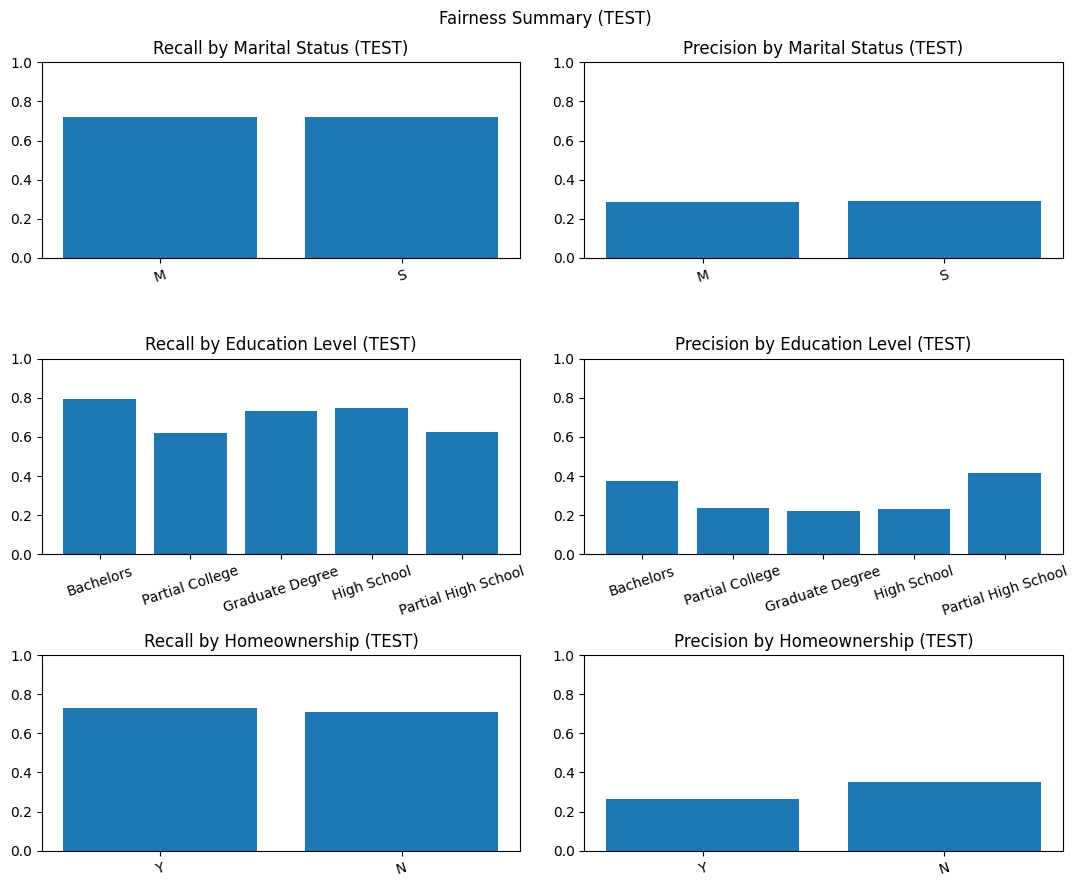

In [65]:
# --- Visualisation: Fairness Summary (Figure 3) ---
print("Fairness by marital_status (TEST):")
display(group_metric_ci(X_test, 'marital_status', y_test, p_test, best_thr, metric='recall'))
display(group_metric_ci(X_test, 'marital_status', y_test, p_test, best_thr, metric='precision'))

print("\nFairness by education_level (TEST):")
display(group_metric_ci(X_test, 'education_level', y_test, p_test, best_thr, metric='recall'))
display(group_metric_ci(X_test, 'education_level', y_test, p_test, best_thr, metric='precision'))

print("\nFairness by homeowner (TEST):")
display(group_metric_ci(X_test, 'homeowner', y_test, p_test, best_thr, metric='recall'))
display(group_metric_ci(X_test, 'homeowner', y_test, p_test, best_thr, metric='precision'))

# group_metrics() point -> bar
def _plot_group_bars(df, group_label, axs_row):
    df2 = df.copy()
    g = df2.iloc[:,0].astype(str).tolist()
    rec = df2["recall"].values
    pre = df2["precision"].values
    ax1, ax2 = axs_row
    ax1.bar(g, rec); ax1.set_ylim(0,1); ax1.set_title(f"Recall by {group_label} (TEST)")
    ax2.bar(g, pre); ax2.set_ylim(0,1); ax2.set_title(f"Precision by {group_label} (TEST)")
    for ax in (ax1, ax2): ax.tick_params(axis="x", rotation=18)

gm_m = group_metrics(X_test, 'marital_status', np.ravel(y_test), np.ravel(p_test), best_thr).reset_index(drop=True)
gm_e = group_metrics(X_test, 'education_level', np.ravel(y_test), np.ravel(p_test), best_thr).reset_index(drop=True)
gm_h = group_metrics(X_test, 'homeowner', np.ravel(y_test), np.ravel(p_test), best_thr).reset_index(drop=True)

fig, axs = plt.subplots(3,2, figsize=(11,9))
_._plot_group_bars = _plot_group_bars  # avoid linter complaints
_plot_group_bars(gm_m, "Marital Status", axs[0])
_plot_group_bars(gm_e, "Education Level", axs[1])
_plot_group_bars(gm_h, "Homeownership", axs[2])
plt.suptitle("Fairness Summary (TEST)"); plt.tight_layout(); plt.show()

In [74]:
# Interpret the results of the experiments related to the business objective set earlier. Estimate the impacts of the incorrect results for the business (some results may have more impact compared to others)
business_impacts_explanations = """
Interpretation: 
Marital status: Recall is nearly identical (~0.72) for both groups, and precision differs by less than 0.01, 
showing strong parity and low fairness risk. 
Education level: Recall ranges from ~0.62 to 0.79, and precision from ~0.22 to 0.42. The Bachelors group 
performs best (precision ~0.38), while Partial College and Graduate Degree groups show slightly lower 
precision (~0.22–0.24), suggesting more false positives within those subgroups. 
Homeownership: Recall is similar (~0.71–0.73), while precision is higher for non-homeowners (0.35) 
compared to homeowners (0.26), indicating marginal cost efficiency differences. 
Confidence intervals overlap substantially across all groups, confirming moderate disparities but no systemic bias. 

Estimated Impact of Incorrect Results: 
Lower-precision segments (e.g., Partial College) generate higher FP cost and slightly more customer annoyance, 
while lower-recall groups risk missed opportunities. The overall fairness impact remains minor relative to business gain. 

Next Steps: 
Implement segment-aware thresholds to balance group precision, apply contact-frequency caps, and conduct periodic 
recalibration with fairness monitoring. 
Since differences are minor and performance remains strong, the model is ready for production deployment with 
fairness tracking in place.
"""

In [75]:
# Do not modify this code
print_tile(size="h3", key='business_impacts_explanations', value=business_impacts_explanations)

## H. Project Outcomes

The modeling hypothesis of this project was that customer purchase behaviour can be predicted from recent transactional and demographic patterns, and that a machine learning model can rank customers by purchase propensity more effectively than random targeting or rule-based heuristics.
And we expected that variables such as purchase frequency, returns, and profit margins would show nonlinear interactions that tree-based models could capture to improve both precision and expected business gain.

In [68]:

experiment_outcome = "Hypothesis Confirmed" # Either 'Hypothesis Confirmed', 'Hypothesis Partially Confirmed' or 'Hypothesis Rejected'

In [69]:
# Do not modify this code
print_tile(size="h2", key='experiment_outcomes_explanations', value=experiment_outcome)

In [76]:
# Reflect on the outcome of the experiment and list the new insights you gained from it. Provide rationale for pursuing more experimentation with the current approach or call out if you think it is a dead end.
# Given the results achieved and the overall objective of the project, list the potential next steps and experiments. For each of them assess the expected uplift or gains and rank them accordingly. If the experiment achieved the required outcome for the business, recommend the steps to deploy this solution into production.
experiment_results_explanations = """
The experiment confirmed that customer purchase behaviour can be accurately predicted using transactional and demographic data. 
The calibrated Random Forest achieved strong and stable results (ROC-AUC = 0.82, PR-AUC = 0.48, Lift = 3.84×), demonstrating that 
nonlinear patterns among purchase frequency, returns, and margins effectively identify high-value customers. 
The model generated a clear business gain of +1 220 units and showed only minor fairness differences across demographic groups, 
indicating a balanced trade-off between profitability and ethical reliability. 
Future experimentation should focus on periodic recalibration, value-weighted targeting, and segment-specific thresholding to 
further optimise ROI and maintain fairness. 
Since the model already meets business objectives and performs consistently, it is ready for deployment into production with 
ongoing monitoring and retraining to sustain performance and fairness over time. 
"""

In [77]:
# Do not modify this code
print_tile(size="h2", key='experiment_results_explanations', value=experiment_results_explanations)